# Test manifold function

In [2]:
using LinearAlgebra
using DifferentialEquations
using BenchmarkTools
using Plots

In [3]:
include("../R3BP/src/R3BP.jl")

Main.R3BP

In [8]:
## define parameters
paramEM = R3BP.get_cr3bp_param(399, 301)
mu = paramEM.mu
println("mu: $mu")
lp = R3BP.lagrangePoints(mu)

mu: 0.012150584269940354


5×6 Matrix{Float64}:
  0.836915   0.0       0.0  0.0  0.0  0.0
  1.15568    0.0       0.0  0.0  0.0  0.0
 -1.00506    0.0       0.0  0.0  0.0  0.0
  0.487849   0.866025  0.0  0.0  0.0  0.0
  0.487849  -0.866025  0.0  0.0  0.0  0.0

In [35]:
# initial condition of halo
guess_halo = R3BP.halo_analytical_construct(mu, 2, 4500, paramEM.lstar, 1)
res_iter = R3BP.ssdc_periodic_xzplane([mu,], guess_halo.x0, guess_halo.period;
        fix="z", method=Tsit5(), reltol=1e-12, abstol=1e-12);

X0 = res_iter.x0 # [1.176924090973164, 0.0, -0.060210863312217, 0.0, -0.173836346247689, 0.0]
T = res_iter.period #3.385326412831325

3.4138879127057673

In [44]:
function get_manifold(
    mu::Real, state0, period, tf, stable::Bool=true, N::Int=50,
    xdir::String="positive", ϵ=nothing, lstar::Real=384400.0,
)
    #@assert (tf<0 && stable==true) || (tf>0 && stable=false) "check sign of tf!"
    state0_stm = vcat(state0, reshape(I(6), (6^2,)))[:]
    prob_stm = ODEProblem(
        R3BP.rhs_cr3bp_svstm!,
        vcat(state0, reshape(I(6), (6^2,)))[:],
        [0, period],
        [mu,],
        method=Tsit5(), reltol=1e-12, abstol=1e-12, saveat=LinRange(0, period, N+1)
    )
    sol_stm  = solve(prob_stm);
    
    monodromy = R3BP.get_stm(sol_stm, 6)
    λs = eigvals(monodromy)
    vs = eigvecs(monodromy)
    eig_unstb, eig_stb, v_unstb, v_stb = R3BP.get_stable_unstable_eigvecs(λs, vs);
    if stable == true
        y0 = v_stb
    else
        y0 = v_unstb
    end

    # check epsilon, if not provided, check with lstar
    if isnothing(ϵ) == true
        ϵ = scale_ϵ(mu, state0, period, stable, monodromy, y0, lstar)
    end

    # create base ODE
    prob_base = ODEProblem(R3BP.rhs_cr3bp_sv!, state0, (0, tf), [mu,],
        method=Tsit5(), reltol=1e-12, abstol=1e-12,
    )

    sim = []
    for i = 1:N
        # translate eigenvalue
        yi = R3BP.get_stm(sol_stm, 6, 12) * y0
        if yi[1] > 0 && xdir == "positive"
            ϵ_use = ϵ
        elseif yi[1] > 0 && xdir == "negative"
            ϵ_use = -ϵ
        elseif yi[1] < 0 && xdir == "positive"
            ϵ_use = -ϵ
        elseif yi[1] < 0 && xdir == "negative"
            ϵ_use = ϵ
        end
        # translate state
        x0i_ptrb = sol_stm.u[i][1:6] + ϵ_use * yi/norm(yi)
        # propagate
        prob_xi = remake(prob_base; u0=x0i_ptrb)
        push!(sim, solve(prob_xi))
    end
    return sim
end

manifold (generic function with 4 methods)

In [47]:
sim = manifold(X0, T, -12.0, mu, 1e-5);

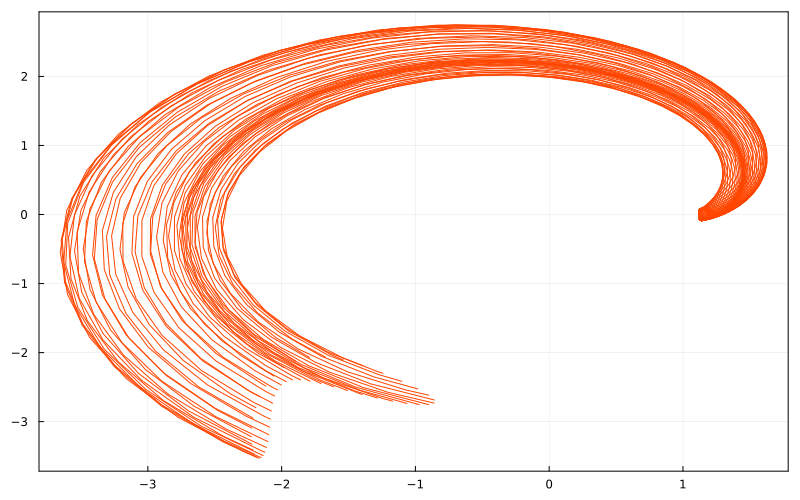

In [51]:
pmanif = plot(frame_style=:box, size=(800,500))
for sol in sim
    plot!(pmanif, Array(sol)[1,:], Array(sol)[2,:], label=false, color=:orangered)
end
pmanif